# Mixed-style workflows

* **Difficulty level**: intemediate
* **Time need to lean**: 20 minutes or less
* **Key points**:
  * The mixed-style workflow consists of both regular and auxiliary steps and can be trigged by both workflow name and targets.

## Mixed style workflows

 <div class="bs-callout bs-callout-primary" role="alert">
    <b>Mixed-style workflows</b> consists of both regular and auxiliary steps and can be triggered as both process-oriented and outcome-oriented styles. It is the most natural way to use SoS.
 </div>

**Process-oriented** or **outcome-oriented** styles are only used to explain two typical camps of workflows. Technically speaking SoS does not enforce any style,

1. If a workflow is specified, SoS collects steps for the workflow and builds a DAG.
2. If one or more targets are specified, SoS locates steps that generates these targets.
3. If any of the `input` or `depends` targets are missing, it extends the DAG according to [step dependency rules](step_dependencies.html).

This approach unifies the two styles and allows users to write workflows in a combination of both styles, which we call a **mixed-style**.

## A process-oriented workflow with auxiliary steps

Auxiliary steps provide a mechanism to produce missing targets and can also be used in forward-time workflows. The resulting workflows have a numbered "stem" steps and an arbitrary number of auxiliary steps that provide required input and dependent files for these steps.

For example, the following example demonstrates the use of a nested workflow with two forward-style workflows with assistance from two auxiliary steps.

touch dbsnp.vcf


touch hg19.fa


align_10


align_20


call_10


call_20


> mixed.dot (4.8 KiB):

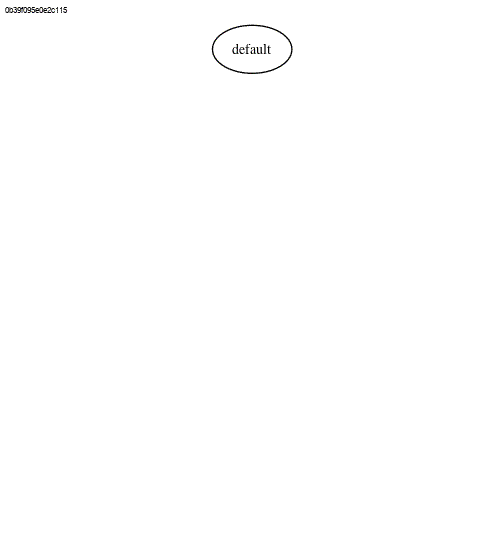

In [1]:
!rm -f hg19.fa dbsnp.vcf

%preview -n mixed.dot
%run -d mixed.dot -v1

[align_10]
depends: 'hg19.fa'
print(step_name)

[align_20]
print(step_name)

[call_10]
depends: 'dbsnp.vcf', 'hg19.fa'
print(step_name)

[call_20]
print(step_name)

[default]
sos_run('align+call')

[refseq: provides='hg19.fa']
run:
    touch hg19.fa

[dbsnp: provides='dbsnp.vcf']
run:
    touch dbsnp.vcf


In this example,

1. A `default` step serves as the entry point for the workflow, which calls a nested workflow `align+call` with the `call` steps executed after the `align` steps.

2. `dbsnp.vcf` and `hg19.fa` are required by steps `align_10` and `call_10`. They are provided by two auxiliary steps so these two steps will be called **only if `dbsnp.csv` and/or `hg19.fa` are missing**.

## A outcome-oriented workflow with forward-style steps

Here is another example of a mixed-style workflow that executes a forward-style workflow to satisfy dependency of a makefile-style workflow.

The example is a bit complex,

1. There is no `default` entry point and the workflow is triggered by `-t vcf`, which is a `named_output` specified in step `call_20`.
2. The output of this step determined from a parameter `sample-name`, which is specified from command line as `--sample-name KS1`.
3. `call_20` is part of a forward-style workflow. Since it does not define any input, it depends upon all its previous steps, which in this case is `call_10`.
4. `call_10` depends on `dbsnp.vcf` and `hg19.fa`, which are generated by auxiliary steps `refseq` and `dbsnp`
5. `call_10` also depends on a named output `bam`, which is trandlated to `KS1_sorted.bam` according to step `align_20`.
6. `KS1_sorted.bam` does not exist so `align_20` is needed, and for the same reason, `align_10` has to be executed.

So in the end we have obtained the same DAG as the previous one, but as you can see the way this DAG is constructed is vastly different.

touch hg19.fa


touch dbsnp.vcf


align_10


align_20


call_10


call_20


> mixed1.dot (4.1 KiB):

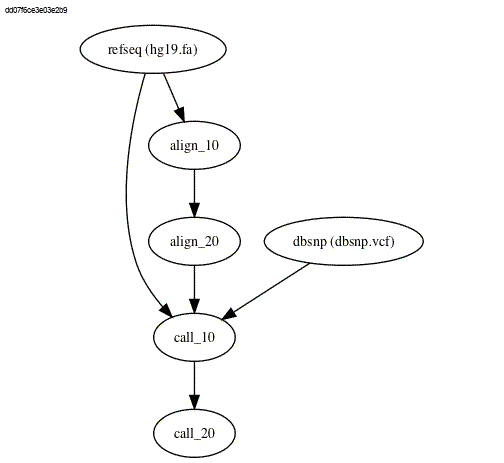

In [2]:
!rm -f hg19.fa dbsnp.vcf KS1.vcf KS1.bam KS1_sorted.bam

%preview -n mixed1.dot
%run -v1 -d mixed1.dot --sample-name KS1 -t vcf

parameter: sample_name = str

[align_10]
depends: 'hg19.fa'
output: f'{sample_name}.bam'
print(step_name)
_output.touch()

[align_20]
output: bam=f'{sample_name}_sorted.bam'
print(step_name)
_output.touch()

[call_10]
depends: 'dbsnp.vcf', 'hg19.fa', named_output('bam')
print(step_name)

[call_20]
output: vcf=f'{sample_name}.vcf'
print(step_name)
_output.touch()

[refseq: provides='hg19.fa']
run:
    touch hg19.fa

[dbsnp: provides='dbsnp.vcf']
run:
    touch dbsnp.vcf

### Multiple ways to execute the same workflow

The use of nested workflows that construct and execute workflows in both process-oriented and outcome-oriented styles allows even more flexible execution of SoS workflows but here we just use `sos_run` to demonstrate potential multiple ways to execute a workflow.

In [3]:
%run -T -s force -v1

[gzip: provides='{name}.gz']
input: f"{name}"
print(f"> {step_name} {_input} to {_output}")
_output.touch()

[download: provides='{name}.pdf']
print(f"> {step_name} {_output}")
_output.touch()

[process_10]
print(f"> Running step {step_name}")

[process_20]
depends: "step20.pdf"
output: "step20.out"
print(f"> Running step {step_name} to produce {_output}")
_output.touch()

[process_30]
output: "step30.out"
print(f"> Running step {step_name} to produce {_output}")
_output.touch()

[default]
print("Forward-style workflow")
sos_run("process")

print("\nMakefile-style workflow")
sos_run(targets="ms.pdf.gz")

print("\nTargets from forward-style workflow")
sos_run(targets="step20.out")

print("\nTargets from forward-style and makefile-style workflows")
sos_run(targets=["step20.out", "ms1.pdf.gz"])

print("\nExecute both workflow and additional steps to generate targets")
sos_run("process", targets=["ms1.pdf.gz"])


Forward-style workflow


> Running step process_10


> download step20.pdf


> Running step process_20 to produce step20.out


> Running step process_30 to produce step30.out


Makefile-style workflow


> download ms.pdf


> gzip ms.pdf to ms.pdf.gz


Targets from forward-style workflow


> Running step process_10


> download step20.pdf


> Running step process_20 to produce step20.out


Targets from forward-style and makefile-style workflows


> Running step process_10


> download ms1.pdf


> download step20.pdf


> gzip ms1.pdf to ms1.pdf.gz


> Running step process_20 to produce step20.out


Execute both workflow and additional steps to generate targets


> Running step process_10


> download step20.pdf


> download ms1.pdf


> Running step process_20 to produce step20.out


> gzip ms1.pdf to ms1.pdf.gz


> Running step process_30 to produce step30.out


This example has a forward-style workflow `process` in which step `process_20` depends on an auxiliary step `download`.

1. In the first case with command line equivalence

  ```bash
  sos run myscript process
  ```
  the forward-style workflow `process` is executed but `download` is also executed because it is required by step 20.

2. In the second example
  ```bash
  sos run myscript -t ms.pdf.gz
  ```
  two auxiliary steps `download` and `gzip` are called to produce target `ms.pdf.gz`.
  
3. In the third example
  ```bash
  sos run myscript -t step20.out
  ```
  the `process` workflow is executed partially until it generates target `step20.out`.
  
4. In the fourth example
  ```bash
  sos run myscript -t step20.out ms1.pdf.gz
  ```
  the `process` workflow is executed partially to produce target `step20.out`, and two auxiliary steps are executed to produce the additional target `ms1.pdf.gz`.
  
5. In the last example
  ```bash
  sos run myscript process -t ms1.pdf.gz
  ```
  sos executes the workflow `process`, and because the workflow does not generate `ms1.pdf.gz`, it also runs two auxiliary steps to produce it. 